### 주변 소리(ambient sound) 라벨과 그에 해당하는 확률들

In [1]:
import numpy as np 
import pandas as pd 
import glob 
import random 
import os 

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요
base_folder =  '/home/user/torch_ubuntu/src/data/ETRI_lifelog_dataset'
folder = '/ch2025_data_items'

data_dir = base_folder + folder 


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# --------------------------- # 
# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 


✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: wPedo, shape = (748100, 9)


In [2]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


In [3]:
mAmbience_df.head(10)

,subject_id,timestamp,m_ambience
0,id01,2024-06-26 13:00:10,"[[Music, 0.30902618], [Vehicle, 0.081680894], ..."
1,id01,2024-06-26 13:02:10,"[[Music, 0.62307084], [Vehicle, 0.021118319], ..."
2,id01,2024-06-26 13:04:10,"[[Horse, 0.25209898], [Animal, 0.24263993], [C..."
3,id01,2024-06-26 13:06:10,"[[Speech, 0.93433166], [Inside, large room or ..."
4,id01,2024-06-26 13:08:10,"[[Speech, 0.8935082], [Inside, small room, 0.0..."
5,id01,2024-06-26 13:10:10,"[[Speech, 0.79542226], [Inside, large room or ..."
6,id01,2024-06-26 13:12:10,"[[Speech, 0.8184474], [Buzz, 0.027313255], [In..."
7,id01,2024-06-26 13:14:10,"[[Speech, 0.80110717], [Inside, large room or ..."
8,id01,2024-06-26 13:16:10,"[[Speech, 0.50018805], [Domestic animals, pets..."
9,id01,2024-06-26 13:18:10,"[[Speech, 0.9326062], [Inside, large room or h..."


* 라벨 선정하기

In [4]:
from collections import Counter
import pandas as pd
import numpy as np
import ast


all_labels = []
for index, row in mAmbience_df.iterrows():
    try:
        ambience_array = row['m_ambience']
        for item in ambience_array:
            if len(item) > 0:
                all_labels.append(item[0])
    except Exception as e:
        print(f"Error processing m_ambience at index {index}: {row['m_ambience']}")
        print(f"Error details: {e}")

label_counts = Counter(all_labels)
top_10_labels = label_counts.most_common(10)
top_10_labels

[('Inside, small room', 419651),
 ('Speech', 396387),
 ('Silence', 354232),
 ('Music', 352983),
 ('Narration, monologue', 335203),
 ('Child speech, kid speaking', 332317),
 ('Conversation', 331389),
 ('Speech synthesizer', 322079),
 ('Shout', 320936),
 ('Babbling', 320612)]

>> 기존 상위10개 라벨과 동일함:   
top_10_labels = [   
     "Inside, small room", "Speech", "Silence", "Music", "Narration,     monologue",      "Child speech, kid speaking", "Conversation", "Speech   synthesizer", "Shout", "Babbling"   
] 

* 하위 10개 

In [5]:
bottom_20_labels = label_counts.most_common()[:-21:-1]
# bottom_20_labels

* 전처리 1단계 (basic)

In [6]:

# 지정된 10개 라벨 
top_10_labels = [ 
    "Inside, small room", "Speech", "Silence", "Music", "Narration, monologue", 
    "Child speech, kid speaking", "Conversation", "Speech synthesizer", "Shout", "Babbling" 
] 

def process_mAmbience_top10(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    # 초기화 
    for label in top_10_labels + ['others']: 
        df[label] = 0.0 
    for idx, row in df.iterrows(): 
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience'] 
        others_prob = 0.0 
        for label, prob in parsed: 
            prob = float(prob) 
            if label in top_10_labels: 
                df.at[idx, label] = prob 
            else: 
                others_prob += prob 
        df.at[idx, 'others'] = others_prob 
    return df.drop(columns=['m_ambience']) 

mAmbience_df1= process_mAmbience_top10(mAmbience_df) 
mAmbience_df1.head(10)

,subject_id,timestamp,date,"Inside, small room",Speech,Silence,Music,"Narration, monologue","Child speech, kid speaking",Conversation,Speech synthesizer,Shout,Babbling,others
0,id01,2024-06-26 13:00:10,2024-06-26,0.000000,0.029806,0.0,0.309026,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.272806
1,id01,2024-06-26 13:02:10,2024-06-26,0.000000,0.000000,0.0,0.623071,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.121183
2,id01,2024-06-26 13:04:10,2024-06-26,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.441796
3,id01,2024-06-26 13:06:10,2024-06-26,0.000000,0.934332,0.0,0.001450,0.015863,0.000000,0.004214,0.0,0.0,0.0,0.052928
4,id01,2024-06-26 13:08:10,2024-06-26,0.019385,0.893508,0.0,0.000000,0.005210,0.002692,0.007692,0.0,0.0,0.0,0.031448
5,id01,2024-06-26 13:10:10,2024-06-26,0.004022,0.795422,0.0,0.000000,0.004769,0.000000,0.000000,0.0,0.0,0.0,0.064602
6,id01,2024-06-26 13:12:10,2024-06-26,0.004579,0.818447,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.090313
7,id01,2024-06-26 13:14:10,2024-06-26,0.013447,0.801107,0.0,0.000000,0.005588,0.000000,0.007068,0.0,0.0,0.0,0.050039
8,id01,2024-06-26 13:16:10,2024-06-26,0.035083,0.500188,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.253920
9,id01,2024-06-26 13:18:10,2024-06-26,0.002353,0.932606,0.0,0.000000,0.007375,0.000000,0.000000,0.0,0.0,0.0,0.064641


* RAW 데이터 시각화(시간별)

In [14]:
mAmbience_df1[(mAmbience_df1['Silence']<0.2) & (mAmbience_df1['Silence']>0.0)]

,subject_id,timestamp,date,"Inside, small room",Speech,Silence,Music,"Narration, monologue","Child speech, kid speaking",Conversation,Speech synthesizer,Shout,Babbling,others
105,id01,2024-06-26 16:30:10,2024-06-26,0.282235,0.000000,0.043020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.427968
259,id01,2024-06-26 21:38:10,2024-06-26,0.000000,0.000000,0.056853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.537236
262,id01,2024-06-26 21:44:10,2024-06-26,0.210563,0.000000,0.026665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.376717
264,id01,2024-06-26 21:48:10,2024-06-26,0.129274,0.065923,0.096087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.348561
269,id01,2024-06-26 21:58:10,2024-06-26,0.058280,0.000000,0.050835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.526564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476410,id10,2024-09-26 18:26:10,2024-09-26,0.012013,0.001899,0.003223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.077560
476415,id10,2024-09-26 18:36:10,2024-09-26,0.003094,0.000000,0.001432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.104881
476416,id10,2024-09-26 18:38:10,2024-09-26,0.003038,0.000000,0.000989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.054486
476423,id10,2024-09-26 18:52:10,2024-09-26,0.157105,0.000000,0.065829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.543558


In [15]:
mAmbience_df1['Silence'].value_counts()

Silence
1.000000    319718
0.000000    122345
0.147235         2
0.065523         2
0.970361         2
             ...  
0.046718         1
0.042489         1
0.039903         1
0.165060         1
0.060321         1
Name: count, Length: 34496, dtype: int64

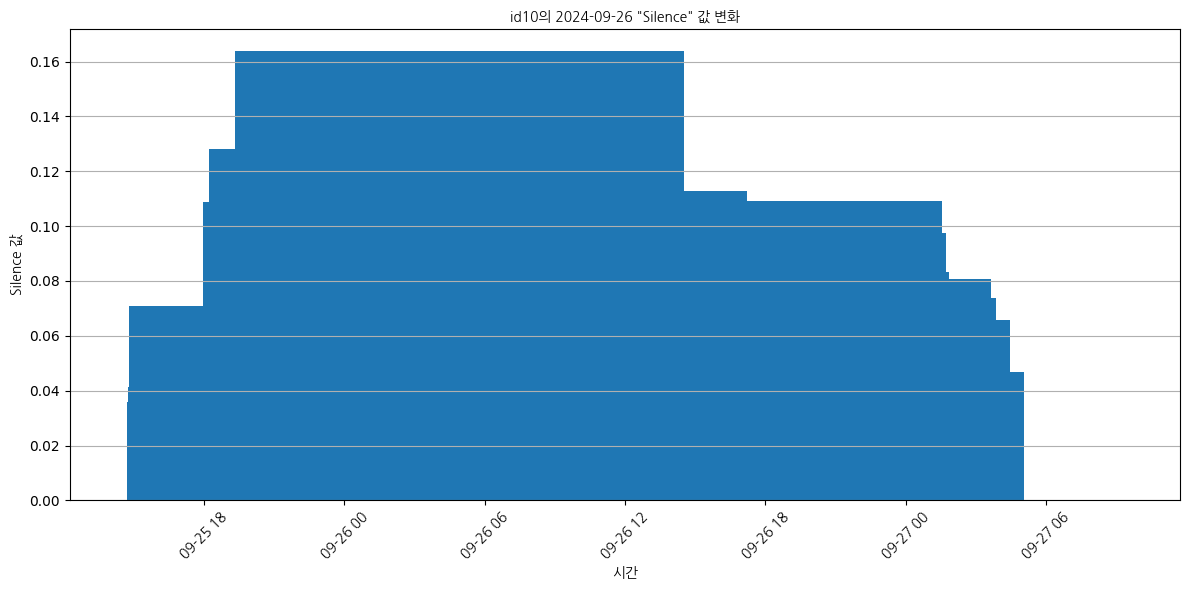

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd

# 나눔고딕 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)


# 그래프를 그리고 싶은 특정 날짜 등을 지정합니다.
ID = 'id10'
target_date = '2024-09-26' #'2024-06-28'
COL = 'Silence'  # 'Inside, small room'

df = mAmbience_df1[mAmbience_df1['subject_id']==ID].copy()

# 'date' 컬럼을 datetime 형식으로  
df['date'] = pd.to_datetime(df['date'])

# 원하는 날짜의 데이터만 필터링합니다.
daily_data = df[df['date'] == target_date].copy()

# 'timestamp' 컬럼을 datetime 형식으로  
daily_data['timestamp'] = pd.to_datetime(daily_data['timestamp'])
daily_data = daily_data.sort_values(by='timestamp')

# 그래프를 그립니다.

target_date = pd.to_datetime(target_date)  # 문자열 -> datetime 변환
date_str = str(target_date.date())         # .date() 사용 가능

plt.figure(figsize=(12, 6))
plt.bar(daily_data['timestamp'], daily_data[COL])  # plot 대신 bar 사용
plt.xlabel('시간', fontproperties=font_prop)
plt.ylabel(f'{COL} 값', fontproperties=font_prop)
plt.title(f'{ID}의 {date_str} "{COL}" 값 변화', fontproperties=font_prop)
plt.grid(True, axis='y')
plt.xticks(rotation=45, fontproperties=font_prop)  # x축 레이블 폰트 적용
plt.tight_layout()
plt.show()

In [ ]:
mAmbience_df1.columns

Index(['subject_id', 'timestamp', 'date', 'Inside, small room', 'Speech',
       'Silence', 'Music', 'Narration, monologue',
       'Child speech, kid speaking', 'Conversation', 'Speech synthesizer',
       'Shout', 'Babbling', 'others'],
      dtype='object')

* [기존 전처리] 시간별 -> 날짜별 (평균값) => 데이터 손실이 클 것 같음

In [ ]:
def summarize_mAmbience_daily_mean(df): 
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']] 
    # 하루 단위로 평균값 요약 
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index() 
    return daily_summary 

mAmbience_df2 = summarize_mAmbience_daily_mean(mAmbience_df1) 
mAmbience_df2.head(10)

,subject_id,date,"Inside, small room",Speech,Silence,Music,"Narration, monologue","Child speech, kid speaking",Conversation,Speech synthesizer,Shout,Babbling,others
0,id01,2024-06-26,2.183661e-02,2.466539e-01,0.116573,3.041167e-02,1.807150e-03,0.000645,0.000919,0.000033,0.000639,0.0,0.500729
1,id01,2024-06-27,5.669892e-05,8.622866e-08,0.998611,7.056701e-15,9.689560e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.001542
2,id01,2024-06-28,1.019045e-05,1.434175e-03,0.995774,7.036657e-15,2.030282e-05,0.000002,0.000002,0.000005,0.000000,0.0,0.003555
3,id01,2024-06-29,3.832783e-04,8.622867e-08,0.998611,7.056701e-15,9.689562e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.002089
4,id01,2024-06-30,2.072503e-27,8.622866e-08,0.998685,7.056702e-15,9.689561e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.000934
5,id01,2024-07-01,2.072429e-27,8.622559e-08,0.998575,7.056448e-15,9.689215e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.002094
6,id01,2024-07-02,5.000739e-05,7.417843e-04,0.998611,3.400207e-04,9.689559e-30,0.000014,0.000000,0.000000,0.000000,0.0,0.000060
7,id01,2024-07-03,2.742395e-04,4.683239e-04,0.995833,7.037073e-15,9.662606e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.003446
8,id01,2024-07-04,2.066738e-27,8.598881e-08,0.995833,7.037072e-15,9.662606e-30,0.000000,0.000000,0.000000,0.000000,0.0,0.002378
9,id01,2024-07-05,6.290886e-05,3.371452e-04,0.998611,3.864497e-05,9.689563e-30,0.000028,0.000000,0.000000,0.000000,0.0,0.000401


* 시간별 -> 날짜별 (최대값)

In [64]:
def summarize_mAmbience_daily(df): 
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']] 
    # 하루 단위로 평균값 요약 
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].max().reset_index() 
    return daily_summary 

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df1) 
mAmbience_df2.head(10)

,subject_id,date,"Inside, small room",Speech,Silence,Music,"Narration, monologue","Child speech, kid speaking",Conversation,Speech synthesizer,Shout,Babbling,others
0,id01,2024-06-26,3.649274e-01,9.776402e-01,1.0,8.460686e-01,1.168274e-01,0.054614,0.031577,0.003973,0.06252,0.0,2.443486
1,id01,2024-06-27,4.082322e-02,8.634999e-08,1.0,7.066520e-15,9.703493e-30,0.000000,0.000000,0.000000,0.00000,0.0,1.110240
2,id01,2024-06-28,7.235220e-03,9.968755e-01,1.0,7.066526e-15,1.441500e-02,0.001367,0.001734,0.003355,0.00000,0.0,1.508797
3,id01,2024-06-29,2.759604e-01,8.634974e-08,1.0,7.066520e-15,9.703437e-30,0.000000,0.000000,0.000000,0.00000,0.0,1.504379
4,id01,2024-06-30,2.075487e-27,8.635002e-08,1.0,7.066540e-15,9.703419e-30,0.000000,0.000000,0.000000,0.00000,0.0,0.672293
5,id01,2024-07-01,2.075471e-27,8.634907e-08,1.0,7.066547e-15,9.703382e-30,0.000000,0.000000,0.000000,0.00000,0.0,1.469743
6,id01,2024-07-02,3.600532e-02,5.340226e-01,1.0,2.448149e-01,9.703400e-30,0.010036,0.000000,0.000000,0.00000,0.0,0.043466
7,id01,2024-07-03,6.993686e-02,3.371313e-01,1.0,7.066560e-15,9.703437e-30,0.000000,0.000000,0.000000,0.00000,0.0,1.414082
8,id01,2024-07-04,2.075487e-27,8.634990e-08,1.0,7.066520e-15,9.703437e-30,0.000000,0.000000,0.000000,0.00000,0.0,0.925327
9,id01,2024-07-05,4.529438e-02,2.426825e-01,1.0,2.782438e-02,9.703456e-30,0.019908,0.000000,0.000000,0.00000,0.0,0.288838


In [ ]:
# 최빈값
# import statistics
# def get_mode(series):
#     """Series의 최빈값을 반환하는 함수. 최빈값이 여러 개일 경우 첫 번째 값 반환."""
#     try:
#         return statistics.mode(series)
#     except statistics.StatisticsError:
#         # 최빈값이 여러 개일 경우 처리 (여기서는 첫 번째 값 반환)
#         return series.mode().iloc[0]

# def summarize_mAmbience_daily(df):
#     prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']]
#     # 하루 단위로 최빈값 요약
#     daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].agg(get_mode).reset_index()
#     return daily_summary

# # mAmbience_df2가 원본 데이터를 담고 있다고 가정합니다.
# mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2) # 원본 데이터프레임 사용
# mAmbience_df2.head(10)

,subject_id,date,"Inside, small room",Speech,Silence,Music,"Narration, monologue","Child speech, kid speaking",Conversation,Speech synthesizer,Shout,Babbling,others
0,id01,2024-06-26,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1,id01,2024-06-27,2.075384e-27,8.634858e-08,1.0,7.066520e-15,9.703030e-30,0.0,0.0,0.0,0.0,0.0,0.0
2,id01,2024-06-28,2.075384e-27,8.634858e-08,1.0,7.066520e-15,9.703030e-30,0.0,0.0,0.0,0.0,0.0,0.0
3,id01,2024-06-29,2.075384e-27,8.634858e-08,1.0,7.066520e-15,9.703030e-30,0.0,0.0,0.0,0.0,0.0,0.0
4,id01,2024-06-30,2.075384e-27,8.634858e-08,1.0,7.066520e-15,9.703030e-30,0.0,0.0,0.0,0.0,0.0,0.0
5,id01,2024-07-01,2.075384e-27,8.634858e-08,1.0,7.066520e-15,9.703030e-30,0.0,0.0,0.0,0.0,0.0,0.0
6,id01,2024-07-02,2.075384e-27,8.634858e-08,1.0,7.066520e-15,9.703030e-30,0.0,0.0,0.0,0.0,0.0,0.0
7,id01,2024-07-03,2.075384e-27,8.634858e-08,1.0,7.066520e-15,9.703030e-30,0.0,0.0,0.0,0.0,0.0,0.0
8,id01,2024-07-04,2.075384e-27,8.634858e-08,1.0,7.066520e-15,9.703030e-30,0.0,0.0,0.0,0.0,0.0,0.0
9,id01,2024-07-05,2.075384e-27,8.634858e-08,1.0,7.066520e-15,9.703030e-30,0.0,0.0,0.0,0.0,0.0,0.0
